In [1]:
!pip install timm
!pip install monai

In [2]:
import os
from tqdm import tqdm
import pickle
import argparse
import time
import torch
import yaml
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from IPython.display import display

from utils import set_seed, load_model, save, get_model, update_optimizer, get_data
from epoch import train_epoch, val_epoch, test_epoch
from cli import add_all_parsers
import greenstand_utils as gu  # GREENSTAND
from monai.losses import FocalLoss # GREENSTAND


def get_args(hyperparameter_config_file='hyperparameters.yaml'):
    with open(hyperparameter_config_file) as file:
        contents = yaml.safe_load(file)
    new_args = []
    for item in contents:
        new_args.append('--' + item)
        new_args.append(str(contents[item]))
    return new_args


def train(args):
    set_seed(args, use_gpu=torch.cuda.is_available())
    
    # Get Data  # GREENSTAND
    g_args = vars(args) # GREENSTAND
    g_args['prefixes'] = g_args['prefixes'].split(',') # GREENSTAND
    train_loader, val_loader, test_loader, dataset_attributes = gu.sync_split_get_dataloaders(vars(args))  # GREENSTAND
    print(f"Dataset Attributes: {dataset_attributes}") # GREENSTANDS

    model = gu.load_preloaded_model(args, dataset_attributes)  # GREENSTAND - Get pretrained model if specified 
    criteria = FocalLoss(to_onehot_y=True) #BinaryFocalLossWithLogits(alpha=1.0) # GREENSTAND

    if args.use_gpu:
        torch.cuda.set_device(0)
        model.cuda()
        criteria.cuda()

    optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=args.mu) # GREENSTAND
    # optimizer = SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=args.mu, nesterov=True)

    # Containers for storing metrics over epochs
    loss_train, acc_train, topk_acc_train = [], [], []
    loss_val, acc_val, topk_acc_val, avgk_acc_val, class_acc_val = [], [], [], [], []

    save_name = args.save_name_xp.strip()
    save_dir = os.path.join(os.getcwd(), 'results', save_name)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print('args.k : ', args.k)

    lmbda_best_acc = None
    best_val_acc = float('-inf')

    for epoch in tqdm(range(args.n_epochs), desc='epoch', position=0):
        t = time.time()
        optimizer = update_optimizer(optimizer, lr_schedule=dataset_attributes['lr_schedule'], epoch=epoch)

        loss_epoch_train, acc_epoch_train, topk_acc_epoch_train = train_epoch(model, optimizer, train_loader,
                                                                              criteria, loss_train, acc_train,
                                                                              topk_acc_train, args.k,
                                                                              dataset_attributes['n_train'],
                                                                              args.use_gpu)

        loss_epoch_val, acc_epoch_val, topk_acc_epoch_val, \
        avgk_acc_epoch_val, lmbda_val = val_epoch(model, val_loader, criteria,
                                                  loss_val, acc_val, topk_acc_val, avgk_acc_val,
                                                  class_acc_val, args.k, dataset_attributes, args.use_gpu)

        # save model at every epoch
        save(model, optimizer, epoch, os.path.join(save_dir, save_name + '_weights.tar'))

        # save model with best val accuracy
        if acc_epoch_val > best_val_acc:
            best_val_acc = acc_epoch_val
            lmbda_best_acc = lmbda_val
            save(model, optimizer, epoch, os.path.join(save_dir, save_name + '_weights_best_acc.tar'))

        print()
        print(f'epoch {epoch} took {time.time()-t:.2f}')
        print(f'loss_train : {loss_epoch_train}')
        print(f'loss_val : {loss_epoch_val}')
        print(f'acc_train : {acc_epoch_train} / topk_acc_train : {topk_acc_epoch_train}')
        print(f'acc_val : {acc_epoch_val} / topk_acc_val : {topk_acc_epoch_val} / '
              f'avgk_acc_val : {avgk_acc_epoch_val}')

    # load weights corresponding to best val accuracy and evaluate on test
    load_model(model, os.path.join(save_dir, save_name + '_weights_best_acc.tar'), args.use_gpu)
    loss_test_ba, acc_test_ba, topk_acc_test_ba, \
    avgk_acc_test_ba, class_acc_test, confuse = test_epoch(model, test_loader, criteria, args.k,
                                                  lmbda_best_acc, args.use_gpu,
                                                  dataset_attributes)
    
    print("Average test accuracy: {}".format(avgk_acc_test_ba))
    print("Average class accuracies: {}".format(class_acc_test))
    display(confuse)

    # Save the results as a dictionary and save it as a pickle file in desired location

    results = {'loss_train': loss_train, 'acc_train': acc_train, 'topk_acc_train': topk_acc_train,
               'loss_val': loss_val, 'acc_val': acc_val, 'topk_acc_val': topk_acc_val, 'class_acc_val': class_acc_val,
               'avgk_acc_val': avgk_acc_val,
               'test_results': {'loss': loss_test_ba,
                                'accuracy': acc_test_ba,
                                'topk_accuracy': topk_acc_test_ba,
                                'avgk_accuracy': avgk_acc_test_ba,
                                'class_acc_dict': class_acc_test},
               'params': args.__dict__}

    with open(os.path.join(save_dir, save_name + '.pkl'), 'wb') as f:
        pickle.dump(results, f)
        

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [3]:
import json
PLANTNET_SPECIES = "../../../data/plantnet_300K/plantnet300K_species_names.json"
with open(PLANTNET_SPECIES) as file:
    plantnet = json.loads(file.read())


Use CUDA: True
Seed:	 1
Checking to make sure all local files are present...
Checking missing local files based on bucket: treetracker-training-images at prefix haiti/...
No missing items locally.
Checking missing local files based on bucket: treetracker-training-images at prefix herbarium/...
No missing items locally.
Checking missing local files based on bucket: treetracker-training-images at prefix internet_sourced/...
No missing items locally.
Creating metadata file with pre-determined train, val, test splits...
Loading datasets...
Writing metadata.json...
Creating data loaders...
Loading datasets...


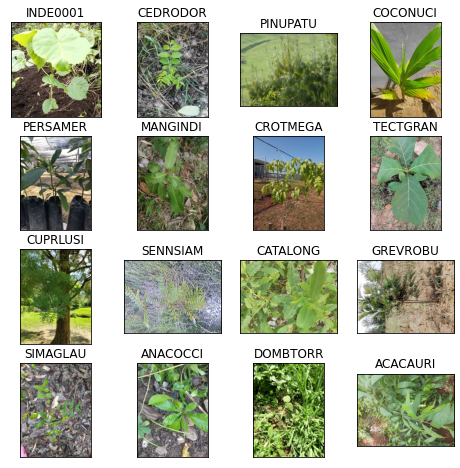

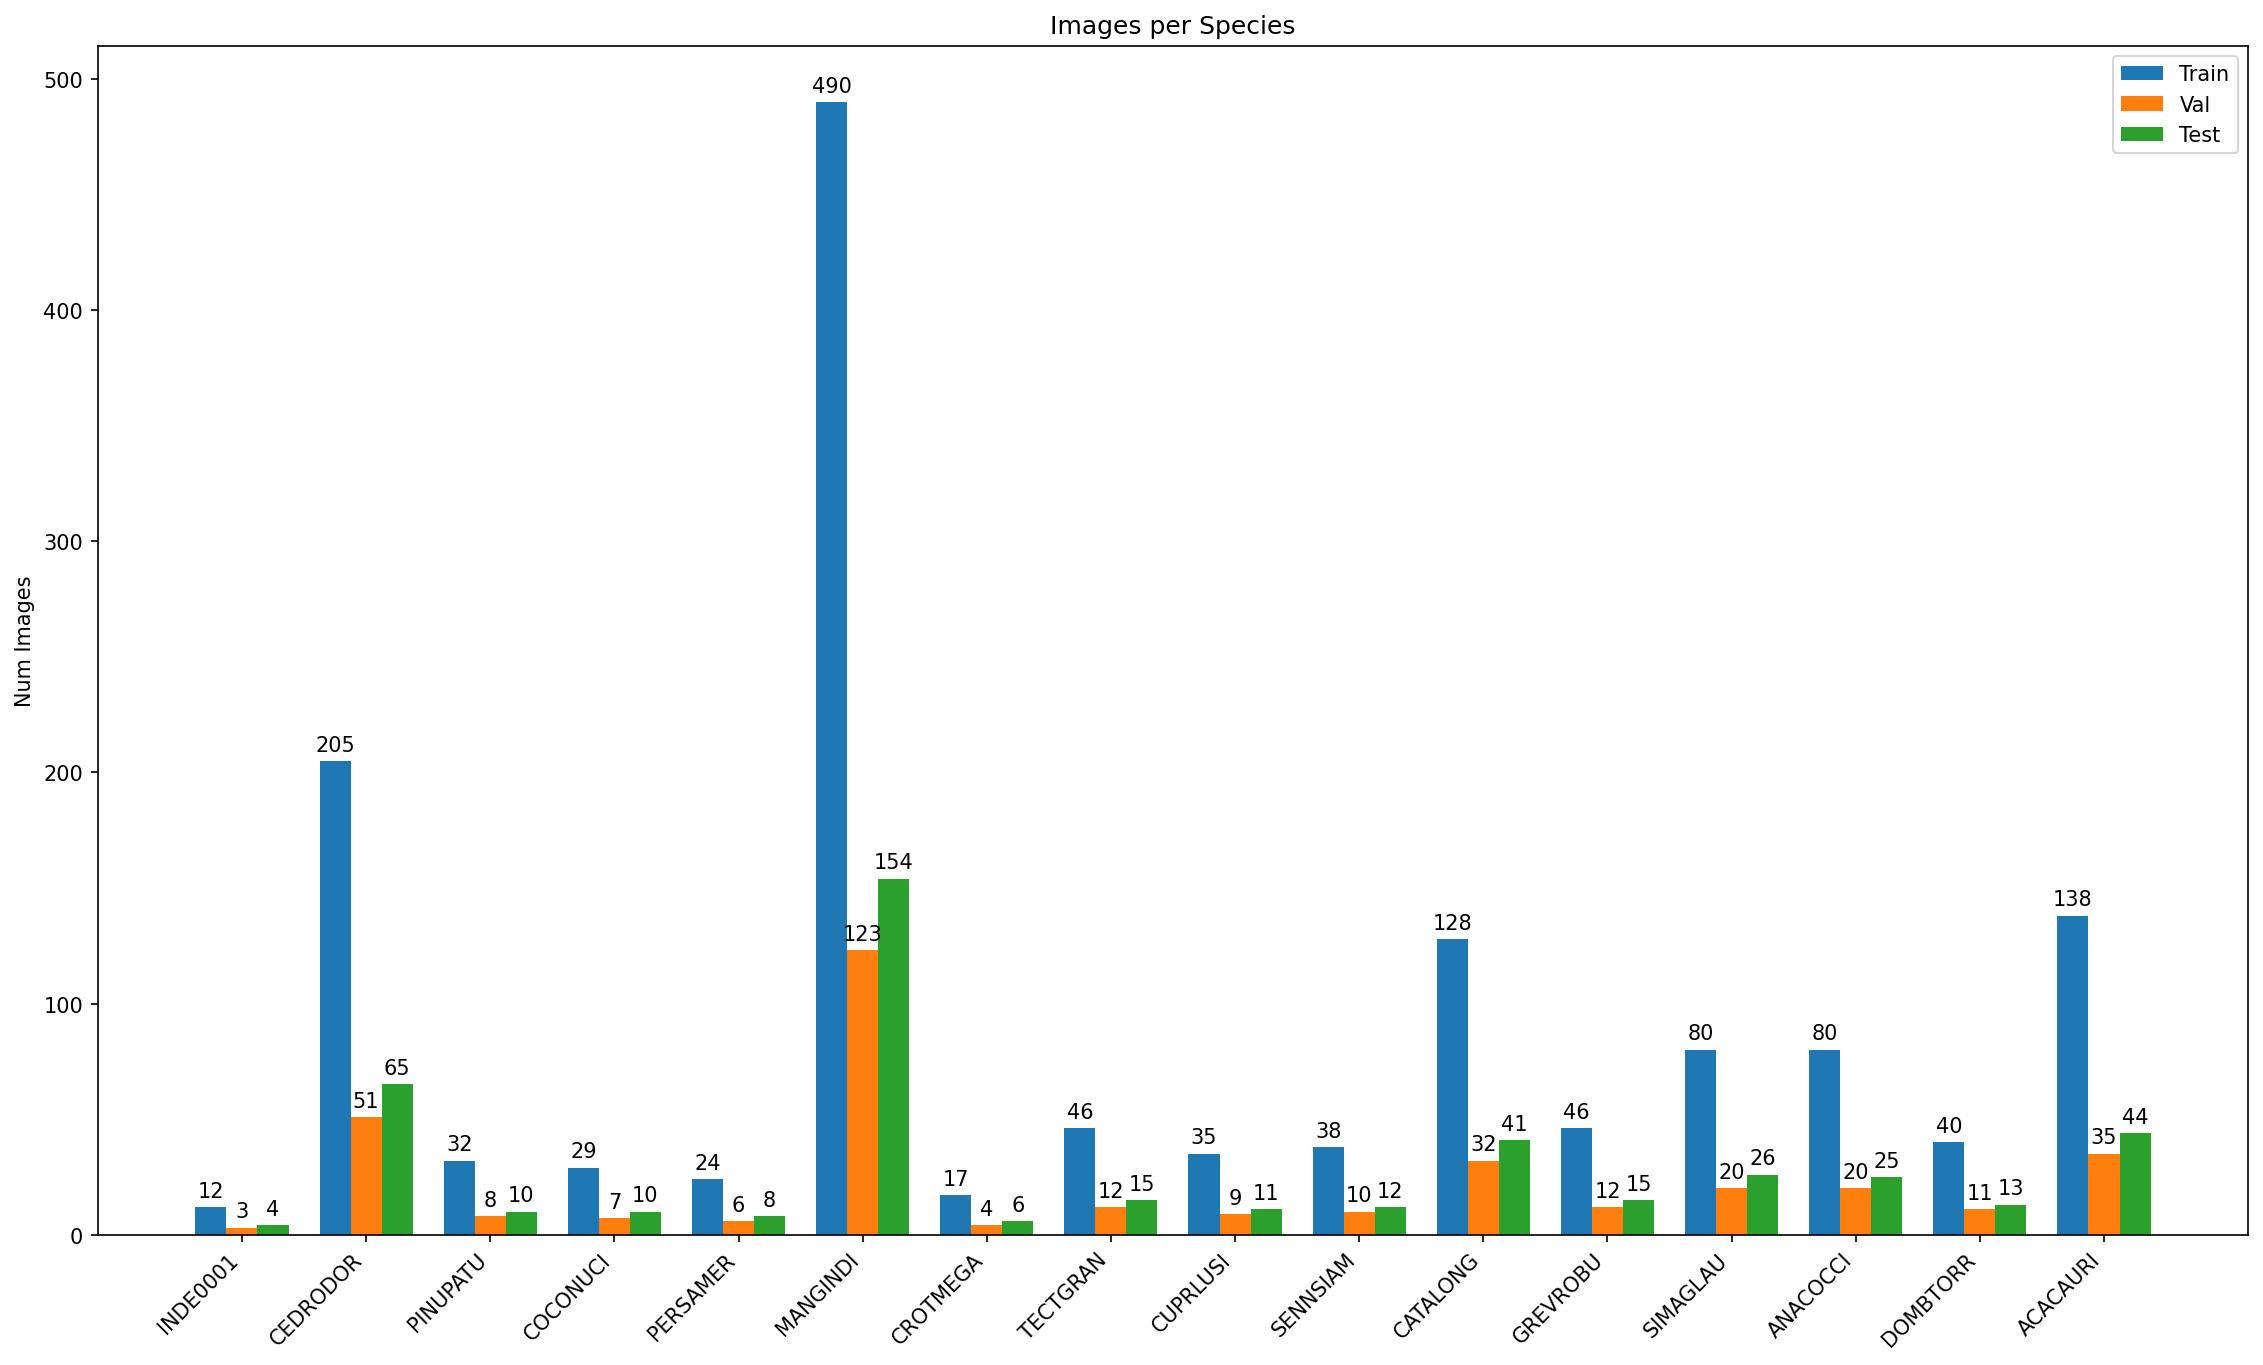

Dataset Attributes: {'n_train': 1440, 'n_val': 363, 'n_test': 459, 'n_classes': 16, 'lr_schedule': [40, 50, 60], 'class2num_instances': {'train': {0: 12, 1: 205, 2: 32, 3: 29, 4: 24, 5: 490, 6: 17, 7: 46, 8: 35, 9: 38, 10: 128, 11: 46, 12: 80, 13: 80, 14: 40, 15: 138}, 'val': {0: 3, 1: 51, 2: 8, 3: 7, 4: 6, 5: 123, 6: 4, 7: 12, 8: 9, 9: 10, 10: 32, 11: 12, 12: 20, 13: 20, 14: 11, 15: 35}, 'test': {0: 4, 1: 65, 2: 10, 3: 10, 4: 8, 5: 154, 6: 6, 7: 15, 8: 11, 9: 12, 10: 41, 11: 15, 12: 26, 13: 25, 14: 13, 15: 44}}, 'class_to_idx': {'INDE0001': 0, 'CEDRODOR': 1, 'PINUPATU': 2, 'COCONUCI': 3, 'PERSAMER': 4, 'MANGINDI': 5, 'CROTMEGA': 6, 'TECTGRAN': 7, 'CUPRLUSI': 8, 'SENNSIAM': 9, 'CATALONG': 10, 'GREVROBU': 11, 'SIMAGLAU': 12, 'ANACOCCI': 13, 'DOMBTORR': 14, 'ACACAURI': 15}, 'invalid_classes': [], 'total_instances_per_class': {'INDE0001': 19, 'CEDRODOR': 321, 'PINUPATU': 50, 'COCONUCI': 46, 'PERSAMER': 38, 'MANGINDI': 767, 'CROTMEGA': 27, 'TECTGRAN': 73, 'CUPRLUSI': 55, 'SENNSIAM': 60, 'C

train:   0%|          | 0/90 [00:00<?, ?it/s]

[2022-08-16 18:46:20.412 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:9646 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?


[2022-08-16 18:46:20.554 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:9646 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


val:   0%|          | 0/23 [00:00<?, ?it/s]/root/greenstand-planetnet-baseline-p-gv8eryhwlca8/sagemaker-greenstand-planetnet-baseline-p-gv8eryhwlca8-modelbuild/greenstand/epoch.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_proba = F.softmax(batch_output_val)
epoch:  10%|█         | 1/10 [00:21<03:12, 21.35s/it]


epoch 0 took 21.35
loss_train : 0.04174545740059922
loss_val : 0.028211966156959534
acc_train : 0.5791666666666667 / topk_acc_train : {1: 0.5791666666666667}
acc_val : 0.768595041322314 / topk_acc_val : {1: 0.768595041322314} / avgk_acc_val : {1: 0.7713498622589532}


epoch:  20%|██        | 2/10 [00:40<02:41, 20.14s/it]


epoch 1 took 19.30
loss_train : 0.02311476267706812
loss_val : 0.030018625780940056
acc_train : 0.7756944444444445 / topk_acc_train : {1: 0.7756944444444445}
acc_val : 0.8154269972451791 / topk_acc_val : {1: 0.8154269972451791} / avgk_acc_val : {1: 0.8099173553719008}


epoch:  30%|███       | 3/10 [01:00<02:19, 19.93s/it]


epoch 2 took 19.66
loss_train : 0.01793658449785428
loss_val : 0.028517042159695517
acc_train : 0.8340277777777778 / topk_acc_train : {1: 0.8340277777777778}
acc_val : 0.8457300275482094 / topk_acc_val : {1: 0.8457300275482094} / avgk_acc_val : {1: 0.8236914600550964}


epoch:  40%|████      | 4/10 [01:19<01:57, 19.64s/it]


epoch 3 took 19.20
loss_train : 0.016235496843589492
loss_val : 0.021707381248812784
acc_train : 0.8520833333333333 / topk_acc_train : {1: 0.8520833333333333}
acc_val : 0.8539944903581267 / topk_acc_val : {1: 0.8539944903581267} / avgk_acc_val : {1: 0.8457300275482094}


epoch:  50%|█████     | 5/10 [01:37<01:35, 19.14s/it]


epoch 4 took 18.26
loss_train : 0.0148761554129338
loss_val : 0.02156479296867143
acc_train : 0.8708333333333333 / topk_acc_train : {1: 0.8708333333333333}
acc_val : 0.837465564738292 / topk_acc_val : {1: 0.837465564738292} / avgk_acc_val : {1: 0.8484848484848485}


epoch:  60%|██████    | 6/10 [01:55<01:14, 18.71s/it]


epoch 5 took 17.87
loss_train : 0.01352793283844262
loss_val : 0.02150084973651577
acc_train : 0.8972222222222223 / topk_acc_train : {1: 0.8972222222222223}
acc_val : 0.8512396694214877 / topk_acc_val : {1: 0.8512396694214877} / avgk_acc_val : {1: 0.8429752066115702}


epoch:  70%|███████   | 7/10 [02:14<00:56, 18.89s/it]


epoch 6 took 19.27
loss_train : 0.012391972444491105
loss_val : 0.029535687528550625
acc_train : 0.9125 / topk_acc_train : {1: 0.9125}
acc_val : 0.8567493112947658 / topk_acc_val : {1: 0.8567493112947658} / avgk_acc_val : {1: 0.8429752066115702}


epoch:  80%|████████  | 8/10 [02:34<00:38, 19.05s/it]


epoch 7 took 19.38
loss_train : 0.011540575638371572
loss_val : 0.021037024234167555
acc_train : 0.9152777777777777 / topk_acc_train : {1: 0.9152777777777777}
acc_val : 0.859504132231405 / topk_acc_val : {1: 0.859504132231405} / avgk_acc_val : {1: 0.8512396694214877}


epoch:  90%|█████████ | 9/10 [02:52<00:18, 18.69s/it]


epoch 8 took 17.91
loss_train : 0.011134132810899715
loss_val : 0.032120647967200384
acc_train : 0.9208333333333333 / topk_acc_train : {1: 0.9208333333333333}
acc_val : 0.8512396694214877 / topk_acc_val : {1: 0.8512396694214877} / avgk_acc_val : {1: 0.8512396694214877}


epoch: 100%|██████████| 10/10 [03:10<00:00, 19.00s/it]



epoch 9 took 17.83
loss_train : 0.011101061514882224
loss_val : 0.027699527754025025
acc_train : 0.9145833333333333 / topk_acc_train : {1: 0.9145833333333333}
acc_val : 0.8457300275482094 / topk_acc_val : {1: 0.8457300275482094} / avgk_acc_val : {1: 0.8512396694214877}



test:   0%|          | 0/29 [00:00<?, ?it/s]/root/greenstand-planetnet-baseline-p-gv8eryhwlca8/sagemaker-greenstand-planetnet-baseline-p-gv8eryhwlca8-modelbuild/greenstand/epoch.py:162: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_proba_test = F.softmax(batch_output_test)
test: 100%|██████████| 29/29 [00:04<00:00,  6.32it/s]

Average test accuracy: {1: 0.803921568627451}
Average class accuracies: {'class_acc': defaultdict(<class 'int'>, {1: 0.9076923076923077, 9: 0.9166666666666666, 10: 0.6585365853658537, 15: 0.8181818181818182, 6: 0.5, 5: 0.922077922077922, 2: 0.4, 12: 0.5769230769230769, 13: 0.6, 7: 0.6666666666666666, 8: 0.6363636363636364, 3: 0.7, 14: 0.8461538461538461, 11: 0.8666666666666667, 0: 1.0, 4: 0.25}), 'class_topk_acc': {1: defaultdict(<class 'int'>, {1: 0.9076923076923077, 9: 0.9166666666666666, 10: 0.6585365853658537, 15: 0.8181818181818182, 6: 0.5, 5: 0.922077922077922, 2: 0.4, 12: 0.5769230769230769, 13: 0.6, 7: 0.6666666666666666, 8: 0.6363636363636364, 3: 0.7, 14: 0.8461538461538461, 11: 0.8666666666666667, 0: 1.0, 4: 0.25})}, 'class_avgk_acc': {1: defaultdict(<class 'int'>, {1: 0.9538461538461539, 9: 0.9166666666666666, 10: 0.7073170731707317, 15: 0.7954545454545454, 6: 0.5, 5: 0.9025974025974026, 2: 0.5, 12: 0.5769230769230769, 13: 0.6, 7: 0.7333333333333333, 8: 0.6363636363636364, 3

,tp,fp,tn,fn,num_instances,accuracy,precision,recall
INDE0001,4,0,455,0,4,1.000000,1.000000,1.000000
CEDRODOR,59,11,383,6,65,0.907692,0.842857,0.907692
PINUPATU,4,0,449,6,10,0.400000,1.000000,0.400000
COCONUCI,7,3,446,3,10,0.700000,0.700000,0.700000
PERSAMER,2,1,450,6,8,0.250000,0.666667,0.250000
MANGINDI,142,29,276,12,154,0.922078,0.830409,0.922078
CROTMEGA,3,1,452,3,6,0.500000,0.750000,0.500000
TECTGRAN,10,2,442,5,15,0.666667,0.833333,0.666667
CUPRLUSI,7,4,444,4,11,0.636364,0.636364,0.636364
SENNSIAM,11,3,444,1,12,0.916667,0.785714,0.916667


In [4]:
"""To run: python main.py --lr=0.05 --n_epochs=80 --k 1 3 5 10 --model=resnet50 --root=path_to_data --save_name_xp=xp1"""

"""
Provide your arguments here in this format:
[
 argname1, argvalue1,
 argname2, argvalue2
]
"""
print(f"Use CUDA: {torch.cuda.is_available()}")
arg_list = get_args()
parser = argparse.ArgumentParser()
add_all_parsers(parser)
args = parser.parse_args(args=arg_list)
train(args)